# **Модуль 1**

### Подключение библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from torchsummary import summary
from torchvision.models import ResNet50_Weights
import zipfile
from torchvision import datasets
import torchvision.transforms as transforms
from fastai.vision.all import *
%matplotlib inline
from torch.utils.data import Subset
import random
from torchvision import models

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Нейронные сети/Cone vs Popsicle.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset')

### Предварительная обработка данных и нормализация

In [ ]:
train_path = 'TRAIN'
test_path = 'TEST'
classes = ("Cone", "Popsicle")
PATH = "/content/dataset/Cone vs Popsicle/"

transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "TRAIN"), transform=transform)
testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "TEST"), transform=transform)

train_ld = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True, num_workers=2)
test_ld = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle = True, num_workers=2)

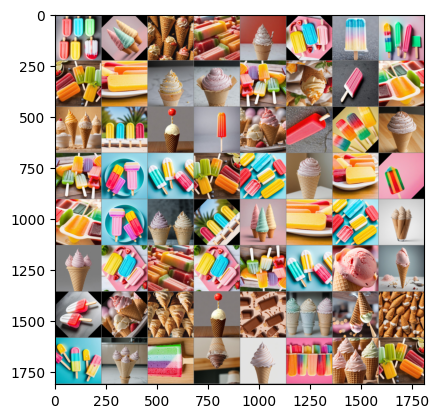

Popsicle Cone  Cone  Popsicle Cone  Popsicle Popsicle Popsicle Popsicle Popsicle Cone  Cone  Popsicle Cone  Popsicle Popsicle Cone  Popsicle Cone  Popsicle Cone  Popsicle Popsicle Cone  Popsicle Popsicle Popsicle Popsicle Popsicle Cone  Popsicle Popsicle Popsicle Popsicle Cone  Popsicle Cone  Popsicle Popsicle Cone  Cone  Popsicle Popsicle Popsicle Popsicle Popsicle Cone  Cone  Popsicle Cone  Cone  Cone  Popsicle Cone  Cone  Cone  Popsicle Cone  Popsicle Cone  Cone  Popsicle Cone  Popsicle


In [ ]:
# Представление данных
# Функции для показа обучающих изображений
def imshow(img):
    img = img  / 2  + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_ld)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **Архитектура 1**

### Определение архитектуры #1

In [ ]:
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3) # первый сверточный слой, kernel_size отвечает за размер сверточного фильтра
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # второй сверточный слой
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # инициализация пулинга к "conv2" (операция, применяется к выходу сверточного слоя, для уменьшения размерности данных)
    self.fc1 = nn.Linear(in_features=32*110*110, out_features=128) # инициализация полносвязных слоев
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,2) # полносвязный слой принимает на вход 64 признака (результат fc2) и имеет 2 выходных нейрона для предсказания принадлежности к классу (Выходной слой)

  def forward(self,x): # функция forward определяет процесс прямого распространения
    x = F.relu(self.conv1(x)) # применение ReLU к сверточному слою
    x = F.relu(self.conv2(x))
    x = self.pool(x) # применение пулинга
    x = torch.flatten(x, 1) # преобразуем тензор x в одномерный тензор
    x = F.relu(self.fc1(x)) # применение ReLU к первому полносвязному слою
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # выходной слой
    return x

In [ ]:
# Позволяет использовать либо GPU, либо CPU для вычислений в зависимости от доступности устройства.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net1 = Net1().to(device)
net1 = net1.cpu()
# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)
# Обучение нейронной сети. Задаем количество эпох обучения
epoch = 10

for epch in range(epoch):
  running_loss = 0.0
  for i, data in enumerate(train_ld):
        # Получение входных данных
        inputs, labels = data # Получение входных данных(изображений) и соответствующие классы
        inputs, labels = inputs.to(device), labels.to(device) # Перемещение входных данных и классов на доступное устройство (GPU или CPU)
        optimizer.zero_grad() # Обнуление градиентов параметров модели
        # Прямой проход
        outputs = net1(inputs) # Прямой проход нейронной сети. Передаем обучающие данные в модель, и она возвращает предсказанные значения.
        loss = criterion(outputs, labels) # Вычисляет значение функции потерь на основе предсказанных значений и истинных меток классов
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()
        # Отслеживание суммарной потери на протяжении эпохи
        running_loss += loss.item()
        # Вывод статистики обучения
        if i % 100 < 99:
            print(f'[{epch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,     1] loss: 0.007
[1,     2] loss: 0.102
[1,     3] loss: 0.008
[1,     4] loss: 0.020
[1,     5] loss: 0.011
[1,     6] loss: 0.008
[1,     7] loss: 0.006
[1,     8] loss: 0.007
[1,     9] loss: 0.008
[2,     1] loss: 0.007
[2,     2] loss: 0.005
[2,     3] loss: 0.005
[2,     4] loss: 0.005
[2,     5] loss: 0.005
[2,     6] loss: 0.005
[2,     7] loss: 0.006
[2,     8] loss: 0.005
[2,     9] loss: 0.004
[3,     1] loss: 0.004
[3,     2] loss: 0.004
[3,     3] loss: 0.003
[3,     4] loss: 0.004
[3,     5] loss: 0.003
[3,     6] loss: 0.003
[3,     7] loss: 0.002
[3,     8] loss: 0.003
[3,     9] loss: 0.002
[4,     1] loss: 0.002
[4,     2] loss: 0.002
[4,     3] loss: 0.003
[4,     4] loss: 0.001
[4,     5] loss: 0.002
[4,     6] loss: 0.002
[4,     7] loss: 0.001
[4,     8] loss: 0.001
[4,     9] loss: 0.001
[5,     1] loss: 0.001
[5,     2] loss: 0.000
[5,     3] loss: 0.001
[5,     4] loss: 0.000
[5,     5] loss: 0.001
[5,     6] loss: 0.000
[5,     7] loss: 0.001
[5,     8] 

### Оценка модели #1

In [ ]:
correct = 0 # Переменная для количества правильно предсказанных классов
total = 0 # Переменная для общего количества примеров
with torch.no_grad(): # Исключение вычислений, связанные с градиентом(это не требуется), при получении выходных данных. Для ускорения процесса.
    for data in test_ld:
        images, labels = data # Получение входных данных (изображений) и соответствующих меток классов
        images, labels = images.to(device), labels.to(device) # Перемещение данных на GPU (если доступно)
        # Прямой проход
        outputs = net1(images) # Получение выходов модели для входных данных
        _, predicted = torch.max(outputs.data, 1) # Выбор предсказания классоа. Находим индекс класса с максимальным значением из выходов модели
        # Обновление переменных correct и total
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # Увеличение количества правильно предсказанных классов
# Вывод точности модели
print(f"Accuracy of the {total} network: {100 * correct // total} %")

Accuracy of the 60 network: 95 %


In [ ]:
correct_pred = {classname: 0 for classname in classes} # Словарь для правильно предсказанных классов
total_pred = {classname: 0 for classname in classes} # Словарь для общего количества предсказаний для каждого класса
with torch.no_grad():
    for data in test_ld:
        images, labels = data
        # Прямой проход
        outputs = net1(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # Обновление счетчиков правильных и общих предсказаний для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# Вывод точности модели для каждого класса
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for the class: {classname:5s} is {accuracy:.1f} %')

accuracy_mod1 = {classname: 100 * correct_pred [classname] / total_pred[classname] for classname in classes}

Accuracy for the class: Cone  is 100.0 %
Accuracy for the class: Popsicle is 90.0 %


### **Архитектура 2**

### Определение архитектуры #2

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # первый сверточный слой
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # операция пулинга
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512) # первый полносвязный слой
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2) # выходной слой

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # применение ReLU к первому сверточному слою, затем операция пулинга
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # преобразование тензора x в одномерный тензор
        x = F.relu(self.fc1(x)) # применение ReLU к первому полносвязному слою
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # выходной слой
        return x

In [ ]:
# Позволяет использовать либо GPU, либо CPU для вычислений в зависимости от доступности устройства.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net2 = Net2().to(device)
net2 = net2.cpu()
# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
# Обучение нейронной сети. Задаем количество эпох обучения
epoch = 10

for epch in range(epoch):
  running_loss = 0.0
  for i, data in enumerate(train_ld):
        # Получение входных данных
        inputs, labels = data # Получение входных данных(изображений) и соответствующие классы
        inputs, labels = inputs.to(device), labels.to(device) # Перемещение входных данных и классов на доступное устройство (GPU или CPU)
        optimizer.zero_grad() # Обнуление градиентов параметров модели
        # Прямой проход
        outputs = net2(inputs) # Прямой проход нейронной сети. Передаем обучающие данные в модель, и она возвращает предсказанные значения.
        loss = criterion(outputs, labels) # Вычисляет значение функции потерь на основе предсказанных значений и истинных меток классов
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()
        # Отслеживание суммарной потери на протяжении эпохи
        running_loss += loss.item()
        # Вывод статистики обучения
        if i % 100 < 99:
            print(f'[{epch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,     1] loss: 0.007
[1,     2] loss: 0.018
[1,     3] loss: 0.008
[1,     4] loss: 0.008
[1,     5] loss: 0.007
[1,     6] loss: 0.007
[1,     7] loss: 0.007
[1,     8] loss: 0.007
[1,     9] loss: 0.007
[2,     1] loss: 0.007
[2,     2] loss: 0.006
[2,     3] loss: 0.006
[2,     4] loss: 0.006
[2,     5] loss: 0.006
[2,     6] loss: 0.005
[2,     7] loss: 0.005
[2,     8] loss: 0.005
[2,     9] loss: 0.005
[3,     1] loss: 0.004
[3,     2] loss: 0.005
[3,     3] loss: 0.004
[3,     4] loss: 0.003
[3,     5] loss: 0.005
[3,     6] loss: 0.005
[3,     7] loss: 0.003
[3,     8] loss: 0.003
[3,     9] loss: 0.005
[4,     1] loss: 0.004
[4,     2] loss: 0.003
[4,     3] loss: 0.003
[4,     4] loss: 0.004
[4,     5] loss: 0.003
[4,     6] loss: 0.003
[4,     7] loss: 0.004
[4,     8] loss: 0.002
[4,     9] loss: 0.002
[5,     1] loss: 0.002
[5,     2] loss: 0.003
[5,     3] loss: 0.002
[5,     4] loss: 0.001
[5,     5] loss: 0.002
[5,     6] loss: 0.001
[5,     7] loss: 0.001
[5,     8] 

### Оценка модели #2

In [ ]:
correct = 0 # Переменная для количества правильно предсказанных классов
total = 0 # Переменная для общего количества примеров
with torch.no_grad(): # Исключение вычислений, связанные с градиентом(это не требуется), при получении выходных данных. Для ускорения процесса.
    for data in test_ld:
        images, labels = data # Получение входных данных (изображений) и соответствующих меток классов
        images, labels = images.to(device), labels.to(device) # Перемещение данных на GPU (если доступно)
        # Прямой проход
        outputs = net2(images) # Получение выходов модели для входных данных
        _, predicted = torch.max(outputs.data, 1) # Выбор предсказания классоа. Находим индекс класса с максимальным значением из выходов модели
        # Обновление переменных correct и total
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # Увеличение количества правильно предсказанных классов
# Вывод точности модели
print(f"Accuracy of the {total} network: {100 * correct // total} %")

Accuracy of the 60 network: 96 %


In [ ]:
correct_pred = {classname: 0 for classname in classes} # Словарь для правильно предсказанных классов
total_pred = {classname: 0 for classname in classes} # Словарь для общего количества предсказаний для каждого класса
with torch.no_grad():
    for data in test_ld:
        images, labels = data
        # Прямой проход
        outputs = net2(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # Обновление счетчиков правильных и общих предсказаний для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# Вывод точности модели для каждого класса
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for the class: {classname:5s} is {accuracy:.1f} %')

accuracy_mod2 = {classname: 100 * correct_pred [classname] / total_pred[classname] for classname in classes}

Accuracy for the class: Cone  is 100.0 %
Accuracy for the class: Popsicle is 93.3 %


### **Архитектура 3**

### Определение архитектуры #3

In [ ]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8, kernel_size=3) # первый сверточный слой
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2) # операция пулинга
        self.conv3_1 = nn.Conv2d(in_channels=8, out_channels=16,kernel_size=3)
        self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3)
        self.conv3_3 = nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3)
        self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv5_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv5_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=32*23*23,out_features=4096) # первый полносвязный слой
        self.fc2 = nn.Linear(4096,1024)
        self.fc3 = nn.Linear(1024,1024)
        self.fc4 = nn.Linear(1024,2) # выходной слой

    def forward(self,x):
        x = F.relu(self.conv1(x)) # применение функции активации ReLU
        x = F.relu(self.conv2(x))
        x = self.pool(x) # применение операции пулинга
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # преобразование тензора x в одномерный тензор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # выходной слой
        return x

In [ ]:
# Позволяет использовать либо GPU, либо CPU для вычислений в зависимости от доступности устройства.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net3 = Net3().to(device)
net3 = net3.cpu()
# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)
# Обучение нейронной сети. Задаем количество эпох обучения
epoch = 10

for epch in range(epoch):
  running_loss = 0.0
  for i, data in enumerate(train_ld):
        # Получение входных данных
        inputs, labels = data # Получение входных данных(изображений) и соответствующие классы
        inputs, labels = inputs.to(device), labels.to(device) # Перемещение входных данных и классов на доступное устройство (GPU или CPU)
        optimizer.zero_grad() # Обнуление градиентов параметров модели
        # Прямой проход
        outputs = net3(inputs) # Прямой проход нейронной сети. Передаем обучающие данные в модель, и она возвращает предсказанные значения.
        loss = criterion(outputs, labels) # Вычисляет значение функции потерь на основе предсказанных значений и истинных меток классов
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()
        # Отслеживание суммарной потери на протяжении эпохи
        running_loss += loss.item()
        # Вывод статистики обучения
        if i % 100 < 99:
            print(f'[{epch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,     1] loss: 0.069
[1,     2] loss: 0.056
[1,     3] loss: 0.015
[1,     4] loss: 0.008
[1,     5] loss: 0.042
[1,     6] loss: 0.021
[1,     7] loss: 0.027
[1,     8] loss: 0.025
[1,     9] loss: 0.018
[2,     1] loss: 0.007
[2,     2] loss: 0.012
[2,     3] loss: 0.013
[2,     4] loss: 0.012
[2,     5] loss: 0.011
[2,     6] loss: 0.007
[2,     7] loss: 0.007
[2,     8] loss: 0.008
[2,     9] loss: 0.008
[3,     1] loss: 0.008
[3,     2] loss: 0.009
[3,     3] loss: 0.009
[3,     4] loss: 0.008
[3,     5] loss: 0.008
[3,     6] loss: 0.007
[3,     7] loss: 0.007
[3,     8] loss: 0.008
[3,     9] loss: 0.008
[4,     1] loss: 0.007
[4,     2] loss: 0.007
[4,     3] loss: 0.007
[4,     4] loss: 0.008
[4,     5] loss: 0.007
[4,     6] loss: 0.007
[4,     7] loss: 0.007
[4,     8] loss: 0.007
[4,     9] loss: 0.007
[5,     1] loss: 0.007
[5,     2] loss: 0.007
[5,     3] loss: 0.007
[5,     4] loss: 0.007
[5,     5] loss: 0.007
[5,     6] loss: 0.007
[5,     7] loss: 0.007
[5,     8] 

### Оценка модели #3

In [ ]:
correct = 0 # Переменная для количества правильно предсказанных классов
total = 0 # Переменная для общего количества примеров
with torch.no_grad(): # Исключение вычислений, связанные с градиентом(это не требуется), при получении выходных данных. Для ускорения процесса.
    for data in test_ld:
        images, labels = data # Получение входных данных (изображений) и соответствующих меток классов
        images, labels = images.to(device), labels.to(device) # Перемещение данных на GPU (если доступно)
        # Прямой проход
        outputs = net3(images) # Получение выходов модели для входных данных
        _, predicted = torch.max(outputs.data, 1) # Выбор предсказания классоа. Находим индекс класса с максимальным значением из выходов модели
        # Обновление переменных correct и total
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # Увеличение количества правильно предсказанных классов
# Вывод точности модели
print(f"Accuracy of the {total} network: {100 * correct // total} %")

Accuracy of the 60 network: 50 %


In [ ]:
correct_pred = {classname: 0 for classname in classes} # Словарь для правильно предсказанных классов
total_pred = {classname: 0 for classname in classes} # Словарь для общего количества предсказаний для каждого класса
with torch.no_grad():
    for data in test_ld:
        images, labels = data
        # Прямой проход
        outputs = net3(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # Обновление счетчиков правильных и общих предсказаний для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# Вывод точности модели для каждого класса
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for the class: {classname:5s} is {accuracy:.1f} %')

accuracy_mod3 = {classname: 100 * correct_pred [classname] / total_pred[classname] for classname in classes}

Accuracy for the class: Cone  is 0.0 %
Accuracy for the class: Popsicle is 100.0 %


### Гистограмма для сравнения трех моделей

(array([1, 2]), [Text(1, 0, 'Cone'), Text(2, 0, 'Popsicle')])

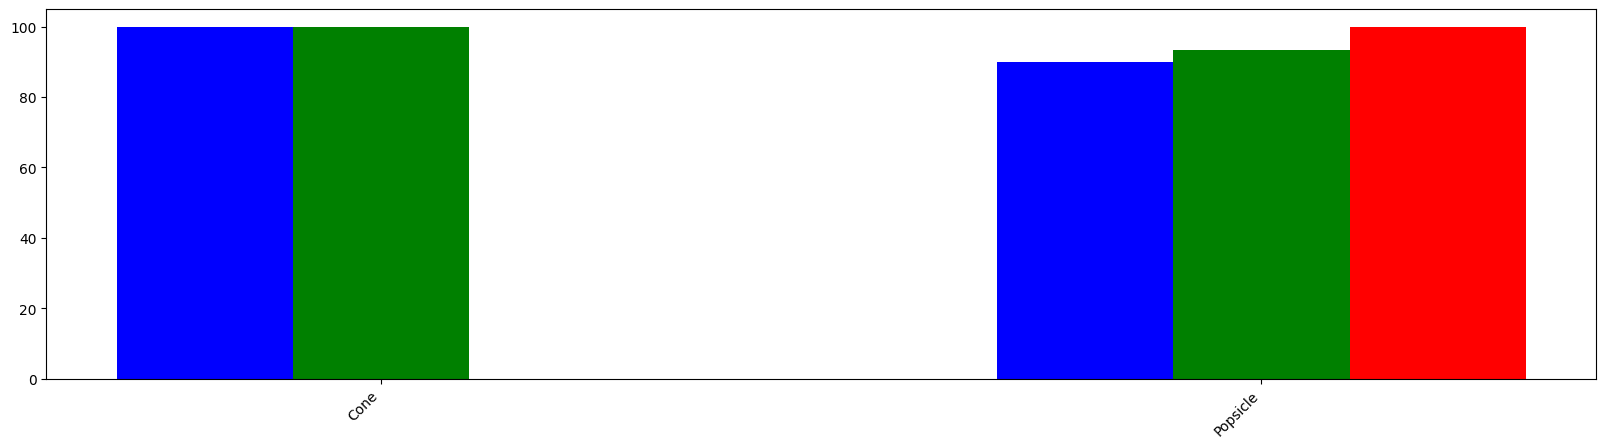

In [ ]:
x1 = np.arange(1, 3) - 0.2
x2 = np.arange(1, 3)
x3 = np.arange(1, 3) + 0.2

y1 = [accuracy_mod1[classname] for classname in classes]
y2 = [accuracy_mod2[classname] for classname in classes]
y3 = [accuracy_mod3[classname] for classname in classes]

fig, ax = plt.subplots()
fig.set_figwidth(20)

ax.bar(x1, y1, width = 0.2, color='blue')
ax.bar(x2, y2, width = 0.2, color='green')
ax.bar(x3, y3, width = 0.2, color='red')
ax.set_xticks(np.arange(1, 3))
ax.set_xticklabels(name for name in classes)
plt.xticks(rotation=45, ha='right')

### Трансферное обучение для решения задачи классификации

In [ ]:
pretrained_alexnet = models.alexnet(pretrained=True)
for param in pretrained_alexnet.parameters():
    param.requires_grad = False
num_features = pretrained_alexnet.classifier[6].in_features
pretrained_alexnet.classifier[6] = nn.Linear(num_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_alexnet = pretrained_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_alexnet.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_ld):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
print('Finished Training\n')

correct = 0 # Оценка точности модели на тестовых данных
total = 0
with torch.no_grad():
    for data in test_ld:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_alexnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {total} test images: {(100 * correct / total):.2f} %')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finished Training

Accuracy of the network on the 60 test images: 100.00 %


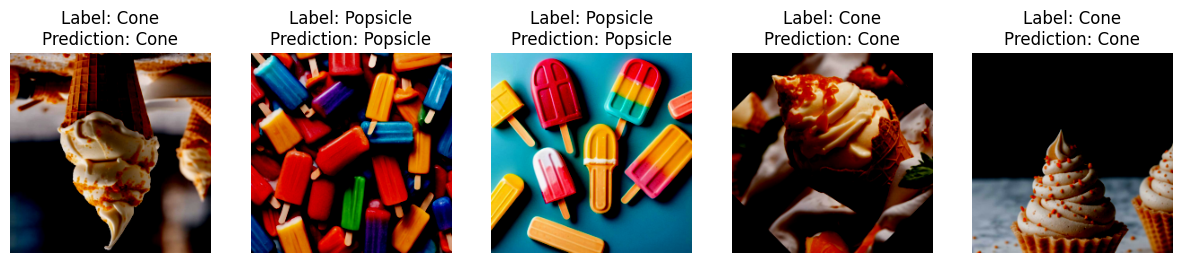

In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        label = class_names[labels[i]]
        prediction = class_names[predicted[i]]

        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}\nPrediction: {prediction}')
        axes[i].axis('off')
    plt.show()
class_names = ['Cone', 'Popsicle']
visualize_predictions(pretrained_alexnet, test_ld, class_names)

# **Модуль 2**

### Подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
# Загружаем датасет
data = pd.read_csv("/content/drive/MyDrive/Нейронные сети/Daily Climate time series data/DailyDelhiClimateTrain.csv")
data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000,1015.666667
1,2013-01-02,7.400000,92.0,2.980,1017.800000
...,...,...,...,...,...
1460,2016-12-31,15.052632,87.0,7.325,1016.100000
1461,2017-01-01,10.000000,100.0,0.000,1016.000000


In [ ]:
# Установка начальной и конечной даты
start_date = dt.datetime(2013, 1, 1)
end_date = dt.datetime(2017, 4, 24)

data['date'] = pd.to_datetime(data['date']) # Преобразование столбца 'date' в формат datetime
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)] # Выборка данных в соответствии с диапазоном дат

In [ ]:
# Определение 80% данных для обучения
training_data_len = math.ceil(len(data) * 0.8)
# Разделение датасета на обучающие и тестовые данные
train_data = data[:training_data_len]
test_data = data[training_data_len:]

print("Training data length:", training_data_len)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data length: 1170
Train data shape: (1170, 5)
Test data shape: (292, 5)


In [ ]:
# Нормализация данных для обучающих и тестовых данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[['meantemp']])
scaled_test = scaler.transform(test_data[['meantemp']])

In [ ]:
# Временные ряды представляются в виде последовательности точек данных, для прогнозирования каждой точки данных
# используется набор предыдущих точек данных, называемый окном (window).

# Формирование обучающих и тестовых данных
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 50

X_train, y_train = create_dataset(scaled_train, window_size)
X_test, y_test = create_dataset(scaled_test, window_size)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (1120, 50, 1) y_train shape: (1120, 1)
X_test shape: (242, 50, 1) y_test shape: (242, 1)


### RNN

In [ ]:
# Sequential Model (Sequential) - тип модели нейронной сети в Keras, который позволяет создавать слои последовательно, один за другим.
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import SGD
import numpy as np

# Создание модели RNN рекуррентными сетями с SimpleRNN, регуляризацей dropout для предотвращения переобучения,
# добавлением выходного слоя с сигмоидной функцией активации и компилируется модель с оптимизатором SGD и функцией потерь MSE.

# Инициализация модели
regressor = Sequential()
# Добавление слоев RNN и регуляризации dropout
regressor.add(SimpleRNN(units=50, # Первый слой. Рекуррентный слой SimpleRNN с 50 нейронами.
                        activation="tanh", # Функция активации для скрытых нейронов.
                        return_sequences=True, # Указывает слою возвращать последовательность выходных значений для каждого временного шага.
                        input_shape=(X_train.shape[1], X_train.shape[2]))) # Форма входных данных.
regressor.add(Dropout(0.2)) # Случайным образом исключает определенное количество нейронов для предотвращения переобучения.
regressor.add(SimpleRNN(units=50,
                        activation="tanh",
                        return_sequences=True))
regressor.add(SimpleRNN(units=50,
                        activation="tanh",
                        return_sequences=True))
regressor.add(SimpleRNN(units=50))
# Добавление выходного слоя
regressor.add(Dense(units=1, activation='sigmoid')) # Последний слой. Полносвязный слой (dense layer) с одним нейроном (используется сигмоидная функция активации). Для предсказания целевой переменной.

# Стохастический градиентный спуск с заданной скоростью обучения
regressor.compile(optimizer=SGD(learning_rate=0.01, # Компиляция модели с оптимизатором SGD и функцией потерь MSE.
                                momentum=0.9, # Коэффициент инерции для ускорения обучения
                                nesterov=True), # Использование улучшенного метода Нестерова
                   loss="mean_squared_error") # Функция потерь (среднеквадратичная ошибка)

In [ ]:
# Обучение модели RNN
regressor.fit(X_train, y_train, epochs=20, batch_size=2)
regressor.summary()

Epoch 1/20
560/560 [==============================] - 25s 40ms/step - loss: 0.0106
Epoch 2/20
560/560 [==============================] - 20s 36ms/step - loss: 0.0056
Epoch 3/20
560/560 [==============================] - 23s 41ms/step - loss: 0.0053
Epoch 4/20
560/560 [==============================] - 21s 38ms/step - loss: 0.0048
Epoch 5/20
560/560 [==============================] - 22s 39ms/step - loss: 0.0045
Epoch 6/20
560/560 [==============================] - 22s 39ms/step - loss: 0.0042
Epoch 7/20
560/560 [==============================] - 22s 38ms/step - loss: 0.0040
Epoch 8/20
560/560 [==============================] - 22s 38ms/step - loss: 0.0040
Epoch 9/20
560/560 [==============================] - 20s 36ms/step - loss: 0.0038
Epoch 10/20
560/560 [==============================] - 22s 39ms/step - loss: 0.0038
Epoch 11/20
560/560 [==============================] - 20s 36ms/step - loss: 0.0035
Epoch 12/20
560/560 [==============================] - 21s 37ms/step - loss: 0.0035
E

### LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Созданием модели с использованием слоев LSTM. LSTM служит для работы с последовательными данными, позволяя модели учитывать долгосрочные зависимости.
# Компилируется модель с оптимизатором Adam и функцией потерь среднеквадратичной ошибки (MSE)

# Инициализация модели
regressorLSTM = Sequential()
# Добавление LSTM слоев
regressorLSTM.add(LSTM(50, # LSTM слой с 50 нейронами
                       return_sequences=True, # указывает, что слой возвращает последовательности
                       input_shape=(X_train.shape[1], X_train.shape[2]))) # Форма входных данных
regressorLSTM.add(LSTM(50,
                       return_sequences=False)) # слой не возвращает последовательности: он работает с выходными данными только последнего временного шага
regressorLSTM.add(Dense(25)) # Полносвязный слой (dense layer) с 25 нейронами
# Добавление выходного слоя
regressorLSTM.add(Dense(1)) # Последний слой с одним нейроном. Для предсказания целевой переменной.

# Компиляция модели
regressorLSTM.compile(optimizer='adam', # Оптимизатор Adam
                      loss='mean_squared_error', # Функция потерь MSE
                      metrics=["accuracy"])

In [ ]:
# Обучение модели LSTM
regressorLSTM.fit(X_train,
                  y_train,
                  batch_size=1,
                  epochs=12)
regressorLSTM.summary()

Epoch 1/12
1120/1120 [==============================] - 33s 26ms/step - loss: 0.0077 - accuracy: 8.9286e-04
Epoch 2/12
1120/1120 [==============================] - 31s 28ms/step - loss: 0.0044 - accuracy: 8.9286e-04
Epoch 3/12
1120/1120 [==============================] - 31s 28ms/step - loss: 0.0038 - accuracy: 8.9286e-04
Epoch 4/12
1120/1120 [==============================] - 30s 27ms/step - loss: 0.0033 - accuracy: 8.9286e-04
Epoch 5/12
1120/1120 [==============================] - 30s 27ms/step - loss: 0.0034 - accuracy: 8.9286e-04
Epoch 6/12
1120/1120 [==============================] - 29s 26ms/step - loss: 0.0033 - accuracy: 8.9286e-04
Epoch 7/12
1120/1120 [==============================] - 30s 27ms/step - loss: 0.0033 - accuracy: 8.9286e-04
Epoch 8/12
1120/1120 [==============================] - 31s 28ms/step - loss: 0.0032 - accuracy: 8.9286e-04
Epoch 9/12
1120/1120 [==============================] - 29s 26ms/step - loss: 0.0032 - accuracy: 8.9286e-04
Epoch 10/12
1120/1120 [=====

### GRU

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import SGD
import numpy as np

# Созданием модели с использованием слоев GRU. В ней используется регуляризация Dropout для предотвращения переобучения.
# Модель из четырех слоев GRU с функцией активации tanh и одного выходного слоя с функцией активации relu.
# Компилируется модель с оптимизатором стохастического градиентного спуска (SGD) и функцией потерь среднеквадратичной ошибки (MSE).

# Инициализация модели
regressorGRU = Sequential()
# Добавление GRU слоев с регуляризацией Dropout
regressorGRU.add(GRU(units=50,# Добавление GRU слоя с 50 нейронами
                     return_sequences=True,# Указывает, что слой возвращает последовательности
                     input_shape=(X_train.shape[1], X_train.shape[2]),# Форма входных данных
                     activation='tanh'))# Функция активации tanh - Гиперболический тангенс
regressorGRU.add(Dropout(0.2))# Регуляризация Dropout. Случайным образом исключает определенное количество нейронов для предотвращения переобучения.

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))
# Выходной слой
regressorGRU.add(Dense(units=1,
                       activation='relu')) # Полносвязный выходной слой с одним нейроном и функцией активации relu

# Компиляция модели
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, # Оптимизатор SGD с коэффициентом обучения 0.01
                                   momentum=0.9, # Параметр момента для ускорения обучения
                                   nesterov=False), # Отключение использования метода Нестерова
                     loss='mean_squared_error') # Функция потерь - среднеквадратичная ошибка

In [ ]:
# Обучение модели GRU
regressorGRU.fit(X_train, y_train, epochs=20, batch_size=1)
regressorGRU.summary()

Epoch 1/20
1120/1120 [==============================] - 74s 58ms/step - loss: 0.0747
Epoch 2/20
1120/1120 [==============================] - 56s 50ms/step - loss: 0.0064
Epoch 3/20
1120/1120 [==============================] - 58s 52ms/step - loss: 0.0060
Epoch 4/20
1120/1120 [==============================] - 57s 51ms/step - loss: 0.0055
Epoch 5/20
1120/1120 [==============================] - 56s 50ms/step - loss: 0.0057
Epoch 6/20
1120/1120 [==============================] - 55s 49ms/step - loss: 0.0051
Epoch 7/20
1120/1120 [==============================] - 55s 50ms/step - loss: 0.0054
Epoch 8/20
1120/1120 [==============================] - 54s 48ms/step - loss: 0.0052
Epoch 9/20
1120/1120 [==============================] - 54s 49ms/step - loss: 0.0047
Epoch 10/20
1120/1120 [==============================] - 58s 51ms/step - loss: 0.0048
Epoch 11/20
1120/1120 [==============================] - 56s 50ms/step - loss: 0.0044
Epoch 12/20
1120/1120 [==============================] - 56s 50

### Визуализация прогнозируемых данных

8/8 [==============================] - 0s 38ms/step


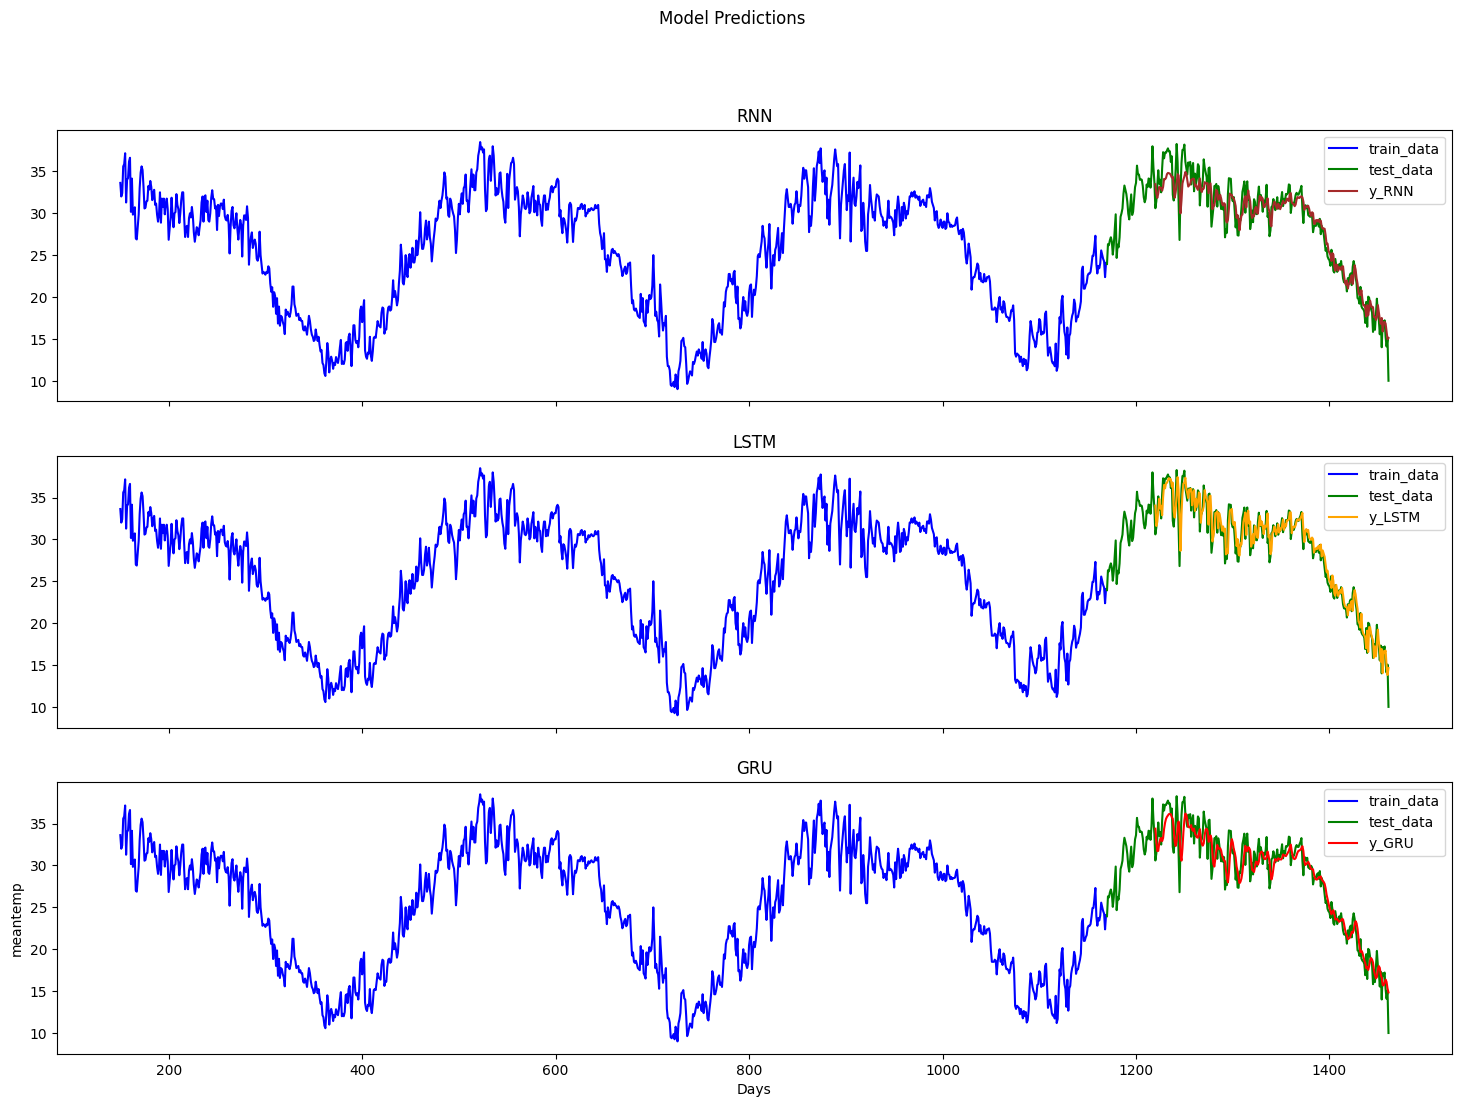

In [ ]:
# Прогнозирование температуры (meantemp) с помощью трех различных моделей рекуррентных нейронных сетей: RNN, LSTM и GRU.
y_RNN = regressor.predict(X_test) # Получение предсказаний модели RNN на тестовом наборе данных
y_LSTM = regressorLSTM.predict(X_test) # Получение предсказаний модели LSTM на тестовом наборе данных
y_GRU = regressorGRU.predict(X_test) # Получение предсказаний модели GRU на тестовом наборе данных

# Обратное преобразование данных из масштабированного диапазона(от 0 до 1) обратно к их исходным значениямю
y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)

fig, axs = plt.subplots(3, figsize=(18, 12), sharex=True, sharey=True)
fig.suptitle('Model Predictions') # Заголовок графика

# Построение графика предсказаний для модели RNN
axs[0].plot(train_data.index[150:], train_data.meantemp[150:], label="train_data", color="b")
axs[0].plot(test_data.index, test_data.meantemp, label="test_data", color="g")
axs[0].plot(test_data.index[50:], y_RNN_O, label="y_RNN", color="brown")
axs[0].legend()
axs[0].set_title("RNN")
# Построение графика предсказаний для модели LSTM
axs[1].plot(train_data.index[150:], train_data.meantemp[150:], label="train_data", color="b")
axs[1].plot(test_data.index, test_data.meantemp, label="test_data", color="g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label="y_LSTM", color="orange")
axs[1].legend()
axs[1].set_title("LSTM")
# Построение графика предсказаний для модели GRU
axs[2].plot(train_data.index[150:], train_data.meantemp[150:], label="train_data", color="b")
axs[2].plot(test_data.index, test_data.meantemp, label="test_data", color="g")
axs[2].plot(test_data.index[50:], y_GRU_O, label="y_GRU", color="red")
axs[2].legend()
axs[2].set_title("GRU")

plt.xlabel("Days")
plt.ylabel("meantemp")

plt.show()

In [ ]:
# R^2 score (коэффициент детерминации).
# Он показывает, насколько хорошо модель соответствует данным относительно среднего значения целевой переменной.
# Значение R^2 лежит в диапазоне от 0 до 1, где 1 означает идеальное соответствие, а 0 означает, что модель не объясняет никакой доли изменчивости в данных.
from sklearn.metrics import r2_score
r2_RNN = r2_score(y_test, y_RNN)
print("Точность модели RNN:", r2_RNN)
r2_LSTM = r2_score(y_test, y_LSTM)
print("\nТочность модели LSTM:", r2_LSTM)
r2_GRU = r2_score(y_test, y_GRU)
print("\nТочность модели GRU:", r2_GRU)

Точность модели RNN: 0.9133930423672509

Точность модели LSTM: 0.9252842492418274

Точность модели GRU: 0.9047158554370851
